# ML Pipeline Code was built for the initial model training.
ML Pipeline Code was built for the initial model training detailed in "Integrated knowledge mining, genome-scale modeling, and machine learning for predicting *Yarrowia lipolytica* bioproduction".

### Part 4/4:
* Part 1: Performs data importation, intial formatting and splits data into 3 parts for training, validation, and testing.
* Part 2: FBA feature generation is completed; script entitled "ML_pipeline_JC_part2"
* Part 3: Feature encoding is completed; script entitled "ML_pipeline_part3"
* Part 4: Machine learning model training is completed; script entitled "ML_pipeline_part4"
    
### Inputs:
* pickle file: Train&ValidateData_part3.pickle from Part 3 is the input to the script. 
    
### Outputs:    
* A pickle grid file containing the trained model.

In [1]:
#This cell imports libraries necessary for the model.

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.offsetbox import AnchoredText
import pickle
import numpy as np
import math
import warnings
from decimal import Decimal, ROUND_DOWN

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer,MinMaxScaler, MaxAbsScaler,Normalizer,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split,ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNet,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF,WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor, ExtraTreesRegressor,BaggingRegressor
from mlxtend.regressor import StackingRegressor,StackingCVRegressor
import xgboost as xgb

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, validation_curve,GridSearchCV,learning_curve,cross_val_score,KFold

from collections import defaultdict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import pearsonr, linregress

#### Cells for code functions.

In [2]:
#This cell contains the functions for the learning curve and scores.
def plot_learning_curve(estimator, title, X, y, ylim=None,xlim=None, cv=10,scorer='neg_mean_absolute_error',n_jobs=5, train_sizes=np.linspace(.8,1,10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)

    if cv is not None:
        cv=cv
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes,shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.savefig('learningCurve_1200.svg',format='svg',dpi=1200)
    plt.legend(loc="best")
    return plt



In [3]:
def rsquared(y_true, y_pred):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(y_true, y_pred)
    return r_value**2
score_rsquared= make_scorer(rsquared, greater_is_better=True)

### Code.

### Ensure the data from Part 3 is in the correct directory.

In [4]:
with open('Train&ValidateData_part3.pickle', 'rb') as f:
    encodedData = pickle.load(f) 
scaledData = encodedData[0]


In [5]:
# Used features in the final model.

cols_train__set = [
# 'dir_evo'
# ,'number_genes_deleted'
# ,'reactor_type'
'mw_Lipids'
,'pH'
,'product_deltaGo'
,'foldCarbonFed'
,'product_name'
# ,'number_total_genes_overexp'
# ,'promoterEncoded(Sum)'
,'rxt_volume'
# ,'N2_contentEncoded'
,'inputThermo(kJ/L)'
# ,'number_genes_mod'
# ,'strain_background'
# ,'oxygen'
,'FermentationTime'
,'atp_cost'
,'precursorsRequiredEncoded'
,'nadh_nadph_cost'
,'Pathway_enzymatic_steps'
#,'no_c'
,'averageThermBarrier'
# ,'totalThermBarrier'
# ,'csConcTotal'
,'media'
,'number_genes_het'
,'number_native_genes_overexp'
# ,'integrationSiteEncoded(Sum)'

,'ATP_iYLI647'
,'NADPH_iYLI647'
# ,'EMP_iYLI647'
,'PPP_iYLI647'
,'TCA_iYLI647'
,'PrdtYield_iYLI647'
#,'O2Uptake_iYLI647'
#,'Biomass_iYLI647'    

    
#production targets are removed from the data before training.
,'Product_titer(g/L)'
,'Product_rate(g/L/h)'
,'Product_yield(g/gC)'#,


]


# targets for ML, drop from feature list before training.
target_cols_todrop = [
'Product_yield(g/gC)'
,'Product_rate(g/L/h)'
,'Product_titer(g/L)'
]


In [6]:
# grab the used features
useful_cols = []
useful_cols.extend(cols_train__set)

data = pd.DataFrame()
data = scaledData.loc[:,useful_cols]

for column in data:
    data[column] = data[column].astype(np.float32)


GSMs=['model_cv10_TAGfeatures']
targetNames = ['yield','titer']
warnings.simplefilter('ignore')

In [7]:
#split data for validation.
train, test = train_test_split(data, test_size = 0.20, random_state = 566, stratify=data['product_name'])


x_train = train.copy()
x_test = test.copy()

#drop the outcome metrics (Titer, yield, rate from database).
for target1 in target_cols_todrop:
    x_train.drop(target1,axis=1,inplace=True)
    x_test.drop(target1,axis=1,inplace=True)

In [8]:
GSMs=['model_iYLI647']
usePCA = 0

In [9]:
#ElasticNet Training.
EN_grid = defaultdict(GridSearchCV)
i=0
target_cols=['Product_titer(g/L)']
scalers_to_test = [StandardScaler(),MaxAbsScaler(),  QuantileTransformer()]#,MinMaxScaler(,RobustScaler(),Normalizer()]#, PowerTransformer()]
alpha_to_test = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
l1_ratios_to_test = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

params = {'scaler': scalers_to_test,
#'reduce_dim':[PCA()],
#'reduce_dim__n_components': n_features_to_test,
'regressor__l1_ratio': l1_ratios_to_test,
'regressor__alpha': alpha_to_test}


for lists in GSMs:
 
    #PCA not used
    if usePCA==1:
        params = {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        'regressor__l1_ratio': l1_ratios_to_test,
        'regressor__alpha': alpha_to_test}
    else:
        params = {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        'regressor__l1_ratio': l1_ratios_to_test,
        'regressor__alpha': alpha_to_test}
    
   
    for target in target_cols:
        #outcome for metric for model eval
        #predicts the log value of the output
        y_train = np.log(train[target])
        y_test = (test[target])
        if usePCA==1:
            temp_pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('pca',PCA(n_components = n_features_to_test)),
                #('reduce_dim', PCA()),
                ('regressor', ElasticNet())
            ])
        else:
            temp_pipe = Pipeline([
                ('scaler', StandardScaler()),
                #('pca',PCA(n_components = n_features_to_test)),
                #('reduce_dim', PCA()),
                ('regressor', ElasticNet())
                #('regressor', model())
            ])

        grid = GridSearchCV(temp_pipe, params, verbose=False,cv=10,n_jobs=1,refit=True,scoring='neg_mean_absolute_error').fit(x_train,y_train)
        EN_grid[target+GSMs[i]]=grid

        y_hat = np.exp(grid.predict(x_test))
        y_train_hat = np.exp(grid.predict(x_train))
        print('EN TRAIN MSE, MAE, and r2')
        print(MSE(y_train_hat,np.exp(y_train)))
        print(mae(y_train_hat,np.exp(y_train)))
        print(rsquared(y_train_hat,np.exp(y_train)))
        print('EN TEST MSE, MAE, and r2')
        print(MSE(y_hat,y_test))
        print(mae((y_hat), y_test))
        print(rsquared((y_hat),y_test))
        print(grid.best_params_)


EN TRAIN MSE, MAE, and r2
349.63055
6.4175596
0.3384318184617683
EN TEST MSE, MAE, and r2
210.60681
5.684793
0.42445171846018204
{'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.9, 'scaler': StandardScaler()}


In [10]:
# kNN Regression  
kNN_grid =defaultdict(GridSearchCV)


i=0
for lists in GSMs:
    alpha_to_test = 2.0**np.arange(-6,+6)
    #PCA not used
    if usePCA==1:
        params= {'scaler': scalers_to_test,
            #'reduce_dim':[PCA()],
            #'reduce_dim__n_components': n_features_to_test,
            # 'regressor__n_neighbors':[i for i in range(5,29)],
            'regressor__n_neighbors':[i for i in range(10,29)],

            'regressor__weights':['uniform','distance']}
    else:
        params= {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        # 'regressor__n_neighbors':[i for i in range(5,29)],
        'regressor__n_neighbors':[i for i in range(10,29)],
        'regressor__weights':['uniform','distance']}

    for target in target_cols:
        #outcome for metric for model eval
        #predicts the log value of the output
        y_train = np.log(train[target])
        y_test = (test[target])
        if usePCA==1:
            temp_pipe = Pipeline([
            ('scaler', StandardScaler()),
            #('reduce_dim', PCA()),
            ('pca',PCA(n_components = n_features_to_test)),
            ('regressor', KNeighborsRegressor())
            ])
        else:
            temp_pipe = Pipeline([
            ('scaler', StandardScaler()),
            #('reduce_dim', PCA()),
            ('regressor', KNeighborsRegressor())
            ])
        grid = GridSearchCV(temp_pipe, params, verbose=False,cv=10,n_jobs=1,refit=True,scoring='neg_mean_absolute_error').fit(x_train, y_train)
        kNN_grid[target+GSMs[i]]=grid


        y_hat = np.exp(grid.predict(x_test))
        y_train_hat = np.exp(grid.predict(x_train))
        print('kNN TRAIN MSE, MAE, and r2')
        print(MSE(y_train_hat,np.exp(y_train)))
        print(mae(y_train_hat,np.exp(y_train)))
        print(rsquared(y_train_hat,np.exp(y_train)))
        print('kNN TEST MSE, MAE, and r2')
        print(MSE(y_hat,y_test))
        print(mae((y_hat), y_test))
        print(rsquared((y_hat),y_test))
        print(grid.best_params_)

kNN TRAIN MSE, MAE, and r2
1.2700919883404341e-12
3.3817966879878324e-07
0.9999999999999971
kNN TEST MSE, MAE, and r2
49.92317095216101
2.729646322863305
0.8490801699277996
{'regressor__n_neighbors': 10, 'regressor__weights': 'distance', 'scaler': MaxAbsScaler()}


In [11]:
#SV Regression
svr_grid =defaultdict(GridSearchCV)


C_dict={'Product_titer(g/L)':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
g_dict={'Product_titer(g/L)':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,'auto']}

for lists in GSMs:

    alpha_to_test = 2.0**np.arange(-6,+6)
    #PCA not used
    if usePCA==1:
        params= {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        'regressor__gamma':g_dict[target],
        'regressor__C':C_dict[target]}
    else:
        params= {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        'regressor__gamma':g_dict[target],
        'regressor__C':C_dict[target]}

    for target in target_cols:
        #outcome for metric for model eval
        #predicts the log value of the output        
        y_train = np.log(train[target])
        y_test = (test[target])

        if usePCA==1:
            temp_pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('pca',PCA(n_components = n_features_to_test)),
                    ('regressor', SVR(kernel='rbf'))
                    ])
        else:
            temp_pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('regressor', SVR(kernel='rbf'))
                    ])
        grid = GridSearchCV(temp_pipe, params, verbose=False,cv=10,n_jobs=5,refit=True,scoring='neg_mean_absolute_error').fit(x_train, y_train)
        svr_grid[target+GSMs[i]]=grid

        y_hat = np.exp(grid.predict(x_test))
        y_train_hat = np.exp(grid.predict(x_train))
        print('SVR TRAIN MSE, MAE, and r2')
        print(MSE(y_train_hat,np.exp(y_train)))
        print(mae(y_train_hat,np.exp(y_train)))
        print(rsquared(y_train_hat,np.exp(y_train)))
        print('SVR TEST MSE, MAE, and r2')
        print(MSE(y_hat,y_test))
        print(mae((y_hat), y_test))
        print(rsquared((y_hat),y_test))
        print(grid.best_params_)

SVR TRAIN MSE, MAE, and r2
13.627613942072813
1.2725208549913956
0.9737531981955759
SVR TEST MSE, MAE, and r2
44.6050287973357
2.6493288343549923
0.8631679334531439
{'regressor__C': 100, 'regressor__gamma': 0.1, 'scaler': StandardScaler()}


In [12]:
#Gaussian Process Regression

GPR_grid =defaultdict(GridSearchCV)
GPR_data_noise_alpha_to_test = 2.0**np.arange(-10,+6)
#rbf
#matern kernel, v=3/2 and v=5/2
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
for lists in GSMs:
    #PCA not used
    if usePCA==1:
        params= {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        #'regressor__kernel':[Matern,RBF],
        'regressor__alpha':GPR_data_noise_alpha_to_test}
    else:
        params= {'scaler': scalers_to_test,
        #'reduce_dim':[PCA()],
        #'reduce_dim__n_components': n_features_to_test,
        #'regressor__kernel':[Matern(nu=2.5),RBF],
        'regressor__alpha':GPR_data_noise_alpha_to_test}

    for target in target_cols:
        #outcome for metric for model eval
        #predicts the log value of the output
        y_train = np.log(train[target])
        y_test = (test[target])
              
        if usePCA==1:
            temp_pipe = Pipeline([
                ('scaler', StandardScaler()),
                #('reduce_dim', PCA()),
                ('pca',PCA(n_components = n_features_to_test)),
                ('regressor', GaussianProcessRegressor(normalize_y=False,random_state=56,n_restarts_optimizer=10))
                ])
        else:
            temp_pipe = Pipeline([
                ('scaler', StandardScaler()),
                #('reduce_dim', PCA()),
                ('regressor', GaussianProcessRegressor(normalize_y=False,random_state=56,n_restarts_optimizer=10))
                ])
        grid = GridSearchCV(temp_pipe, params,verbose=False,cv=10,n_jobs=1,refit=True,scoring='neg_mean_absolute_error').fit(x_train, y_train)
        GPR_grid[target+GSMs[i]]=grid

        y_hat = np.exp(grid.predict(x_test))
        y_train_hat = np.exp(grid.predict(x_train))
        print('GPR TRAIN MSE, MAE, and r2')
        print(MSE(y_train_hat,np.exp(y_train)))
        print(mae(y_train_hat,np.exp(y_train)))
        print(rsquared(y_train_hat,np.exp(y_train)))
        print('GPR TEST MSE, MAE, and r2')
        print(MSE(y_hat,y_test))
        print(mae((y_hat), y_test))
        print(rsquared((y_hat),y_test))
        print(grid.best_params_)

GPR TRAIN MSE, MAE, and r2
31.704711276583986
1.7283545749583231
0.9375677302848757
GPR TEST MSE, MAE, and r2
62.628467568706014
2.9090366312968845
0.8224320604837904
{'regressor__alpha': 0.00390625, 'scaler': QuantileTransformer()}


R^2: 0.77 (+/- 0.01) [EN]
R^2: 0.90 (+/- 0.02) [kNN]
R^2: 0.89 (+/- 0.01) [svr_rbf]
R^2: 0.89 (+/- 0.01) [GPR]
R^2: 0.91 (+/- 0.01) [StackingCVRegressor]
MAE: -1.20 (+/- 0.05) [EN]
MAE: -0.65 (+/- 0.05) [kNN]
MAE: -0.66 (+/- 0.04) [svr_rbf]
MAE: -0.68 (+/- 0.05) [GPR]
MAE: -0.62 (+/- 0.04) [StackingCVRegressor]
For Product_titer(g/L)
***************************************
training:  MAE, MSE, R2:
1.5268603006893335
24.57793177976622
0.955293389248921
test: MAE, MSE, R2
2.3468671601081676
36.883294860662645
0.8870431544153459
(0.9418296843991193, 3.2086544707043747e-215)


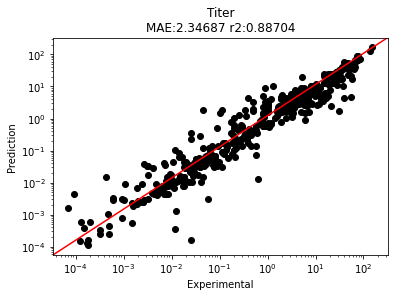

In [13]:
#Ensemble model training

#previous trained models
all_grids=[EN_grid,kNN_grid,svr_grid, GPR_grid]
#seed for Random forest training (ensemble model)
Random_Seed=56
targetTitle = ['Titer','Yield']
test_target = ['Product_titer(g/L)']
i=0
j=0

rf = RandomForestRegressor(random_state=56)

target_cols=['Product_titer(g/L)']

#final trained model holder
master_grids2=defaultdict(GridSearchCV)

for target in target_cols:
    #obtain the outcome metrics
    #predicting the log transformed output
    y_train = np.log(train[target])
    y_test = test[target]

    #obtain the best estimator from the previously trained models
    R_en,R_knr,R_svr,R_gpr =[x[target+'model_iYLI647'].best_estimator_ for x in all_grids]

    #train the ensemble model
    stack = StackingCVRegressor(regressors=(R_en, R_knr,R_svr,R_gpr),
                            meta_regressor=rf,
                            random_state=Random_Seed,
                            use_features_in_secondary=True)
    #cross-validation best R2 score
    for clf1, label1 in zip([R_en, R_knr, R_svr,R_gpr,stack], ['EN', 'kNN','svr_rbf','GPR', 'StackingCVRegressor']):
        scores = cross_val_score(clf1, x_train, y_train)#, cv=10,scoring='neg_mean_absolute_error')
        print("R^2: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label1))
 
    #cross-validation best MAE score
    for clf, label in zip([R_en, R_knr, R_svr,R_gpr,stack], ['EN', 'kNN','svr_rbf','GPR', 'StackingCVRegressor']):
        scores = cross_val_score(clf, x_train, y_train, cv=10,scoring='neg_mean_absolute_error')
        print("MAE: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    #re-fit best ensemble model on entire data.
    clf.fit(x_train,y_train)

    #obtain the predictions (model predicts log transformed values)
    y_hat = np.exp(clf.predict(x_test))
    y_hat_train = np.exp(clf.predict(x_train))

    print('For ' + target)
    print('***************************************')

    #training metrics
    y1=np.exp(clf.predict(x_train))
    print('training:  MAE, MSE, R2:')
    print(mae(np.exp(y_train),y1))
    print(MSE(np.exp(y_train),y1))
    print(rsquared(np.exp(y_train),y1))

    #testing metrics
    y2=np.exp(clf.predict(x_test))
    print('test: MAE, MSE, R2')
    print(mae((y_test),y2))
    print(MSE((y_test),y2))
    print(rsquared((y_test),y2))
    print(pearsonr(y_test,y2))

    text = 'Titer'+'\nMAE:'+str(Decimal(str(mae(y_test,y2))).quantize(Decimal('.00001')))+' r2:'+str(Decimal(str(rsquared(y_test,y2))).quantize(Decimal('0.00001')))
    fig, ax = plt.subplots()
    ax.set_title(text)
    ax.scatter(y_test,y2,c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel('Experimental')
    ax.set_ylabel('Prediction')
    # ax.set_xlim(0,)
    # ax.set_ylim(0,)
    ax.set_xscale('log')
    ax.set_yscale('log')

    master_grids2[target]=clf


In [14]:
#Save final model.
with open('M21iYL_.pickle', 'wb') as f:
    pickle.dump([master_grids2], f)

<module 'matplotlib.pyplot' from '/home/jjczajka/miniconda3/envs/condaPY36lin/lib/python3.6/site-packages/matplotlib/pyplot.py'>

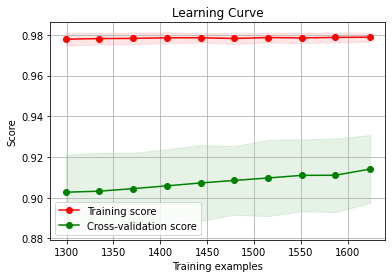

In [15]:
#Learning curve plot.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
title='Learning Curve'
plot_learning_curve(estimator=master_grids2['Product_titer(g/L)'], n_jobs=5,title=title, X=x_train, y=y_train,cv=cv)